# Introduction

This notebook documents possible solutions that could be implemented to increase the accuracy of a Convolutional Neural Network (CNN) model when only small available datasets are provided.

## Table of Content

- [1 - Installation of libraries](#1)
- [2 - Packages](#2)
- [3 - Data Augmentation](#3)
- [4 - Building small dataset](#4)
- [5 - Our Model-1](#5)
    - [5.1 - Transfer Learning using EfficientNet B7](#5-1)
    - [5.2 - Defining loss function and optimizer](#5-2)
    - [5.3 - Training the model](#5-3)
    - [5.4 - Results (Training)](#5-4)
- [6 - Our Model-2](#6)
    - [6.1 - Transfer Learning using Residual Network (ResNet)](#6-1)
    - [6.2 - Defining loss function and optimizer](#6-2)
    - [6.3 - Training the model](#6-3)
    - [6.4 - Results (Training)](#6-4)
- [7 - Testing the 2-in-1 model](#7)
    - [7.1 - Results (Testing)](#7-1)
- [8 - Test on Your Own Image](#8)

    


<a name='1'></a>
## 1 - Installation of libraries (if not installed)

In [ ]:
%pip install torch torchvision

In [ ]:
%pip install numpy

In [ ]:
%pip install matplotlib

<a name='2'></a>
## 2 - Packages

In [1]:
import ssl
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# To resolve certificate error
ssl._create_default_https_context = ssl._create_unverified_context

# Check if GPU is available to be used
device = torch.device('cuda:0' if torch.cuda.is_available()else 'cpu')
print(device)

cuda:0


<a name='3'></a>
## 3 - Data Augmentation



In [3]:
train_transform = transforms.Compose([
     transforms.Resize((256,256)), 
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomCrop(224),
     transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
)])

test_transform = transforms.Compose([
     transforms.Resize((256,256)), 
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
)])

<a name='4'></a>
## 4 - Building small dataset



In [4]:

batch_size = 5
ap_num, am_num,bird_num,cat_num,deer_num = 0,0,0,0,0

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=train_transform)
ap_indices, am_indices, bird_indices, cat_indices, deer_indices = [],[],[],[],[]
ap_idx, am_idx, bird_idx, cat_idx, deer_idx = trainset.class_to_idx['airplane'], trainset.class_to_idx['automobile'], trainset.class_to_idx['bird'], trainset.class_to_idx['cat'], trainset.class_to_idx['deer']
for i in range(len(trainset)):
  current_class = trainset[i][1]
  if current_class == ap_idx:
    if ap_num<50:
      ap_indices.append(i)
      ap_num+=1
  elif current_class == am_idx:
    if am_num<50:
      am_indices.append(i)
      am_num+=1
  elif current_class == bird_idx:
    if bird_num<50:
      bird_indices.append(i)
      bird_num+=1
  elif current_class == cat_idx:
    if cat_num<50:
      cat_indices.append(i)
      cat_num+=1
  elif current_class == deer_idx:
    if deer_num<50:
      deer_indices.append(i)
      deer_num+=1

print('Number of airplane images:%d'%ap_num)
print('Number of automobile images:%d'%am_num)
print('Number of bird images:%d'%bird_num)
print('Number of cat images:%d'%cat_num)
print('Number of deer images:%d'%deer_num)

new_train = torch.utils.data.Subset(trainset,ap_indices+am_indices+bird_indices+cat_indices+deer_indices)

trainloader = torch.utils.data.DataLoader(new_train, batch_size = batch_size,
                                          shuffle=True, num_workers=2)

ap_num, am_num,bird_num,cat_num,deer_num = 0,0,0,0,0

testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=test_transform)
ap_indices, am_indices, bird_indices, cat_indices, deer_indices = [],[],[],[],[]
ap_idx, am_idx, bird_idx, cat_idx, deer_idx = testset.class_to_idx['airplane'], testset.class_to_idx['automobile'], testset.class_to_idx['bird'], testset.class_to_idx['cat'], testset.class_to_idx['deer']
for i in range(len(testset)):
  current_class = testset[i][1]
  if current_class == ap_idx:
    if ap_num<30:
      ap_indices.append(i)
      ap_num+=1
  elif current_class == am_idx:
    if am_num<30:
      am_indices.append(i)
      am_num+=1
  elif current_class == bird_idx:
    if bird_num<30:
      bird_indices.append(i)
      bird_num+=1
  elif current_class == cat_idx:
    if cat_num<30:
      cat_indices.append(i)
      cat_num+=1
  elif current_class == deer_idx:
    if deer_num<30:
      deer_indices.append(i)
      deer_num+=1

print('Number of airplane images:%d'%ap_num)
print('Number of automobile images:%d'%am_num)
print('Number of bird images:%d'%bird_num)
print('Number of cat images:%d'%cat_num)
print('Number of deer images:%d'%deer_num)

new_test = torch.utils.data.Subset(testset,ap_indices+am_indices+bird_indices+cat_indices+deer_indices)

testloader = torch.utils.data.DataLoader(new_test, batch_size = batch_size,
                                         shuffle=False, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer')
           

Files already downloaded and verified
Number of airplane images:50
Number of automobile images:50
Number of bird images:50
Number of cat images:50
Number of deer images:50
Files already downloaded and verified
Number of airplane images:30
Number of automobile images:30
Number of bird images:30
Number of cat images:30
Number of deer images:30


### Displaying augmented images from training dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


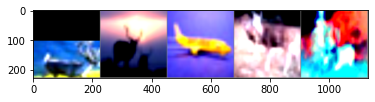

 deer  deer airplane  deer  deer


In [5]:

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' %classes[labels[j]] for j in range(batch_size)))

<a name='5'></a>
## 5 - Our Model 1

<a name='5-1'></a>
### 5.1 - Transfer Learning using EfficientNet B7



In [6]:

efficientnetb7 = models.efficientnet_b7(pretrained=True).to(device)
for param in efficientnetb7.parameters():
    param.requires_grad = False

efficientnetb7.to(device).classifier =  nn.Linear(2560,5)
                                        
efficientnetb7.to(device).eval()

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

<a name='5-2'></a>
### 5.2 - Defining loss function and optimizer for our model

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(efficientnetb7.to(device).parameters(), lr=0.001, momentum=0.9)

<a name='5-3'></a>
### 5.3 - Training the model

In [8]:
running_corrects = 0
total = 0
train_loss = []
train_acc = []

for epoch in range(100):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = efficientnetb7(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)

        running_loss += loss.item()
        total += labels.size(0)
        running_corrects += (predicted == labels).sum().item()
        

        if i%50 == 49:
            print('[%d, %5d]    Loss: %.3f   Accuracy: %.6f'%(epoch+1,i+1,running_loss/50,running_corrects/total))
            train_loss.append(running_loss/50)
            train_acc.append(running_corrects/total)
            running_loss =0.0
            
print('Finished Training')


[1,    50]    Loss: 1.245   Accuracy: 0.704000
[2,    50]    Loss: 0.659   Accuracy: 0.810000
[3,    50]    Loss: 0.508   Accuracy: 0.838667
[4,    50]    Loss: 0.417   Accuracy: 0.854000
[5,    50]    Loss: 0.387   Accuracy: 0.864800
[6,    50]    Loss: 0.363   Accuracy: 0.871333
[7,    50]    Loss: 0.293   Accuracy: 0.877143
[8,    50]    Loss: 0.294   Accuracy: 0.883000
[9,    50]    Loss: 0.300   Accuracy: 0.888000
[10,    50]    Loss: 0.261   Accuracy: 0.891600
[11,    50]    Loss: 0.254   Accuracy: 0.895273
[12,    50]    Loss: 0.285   Accuracy: 0.899000
[13,    50]    Loss: 0.249   Accuracy: 0.901846
[14,    50]    Loss: 0.274   Accuracy: 0.902286
[15,    50]    Loss: 0.289   Accuracy: 0.901867
[16,    50]    Loss: 0.228   Accuracy: 0.904500
[17,    50]    Loss: 0.207   Accuracy: 0.906353
[18,    50]    Loss: 0.242   Accuracy: 0.907333
[19,    50]    Loss: 0.232   Accuracy: 0.908421
[20,    50]    Loss: 0.195   Accuracy: 0.910000
[21,    50]    Loss: 0.196   Accuracy: 0.912381
[

<a name='5-4'></a>
### 5.4 - Results (Training)

#### Loss Curve

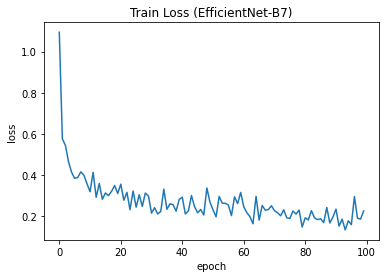

In [28]:
plt.plot(train_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train Loss (EfficientNet-B7)')
plt.show()

#### Accuracy Curve

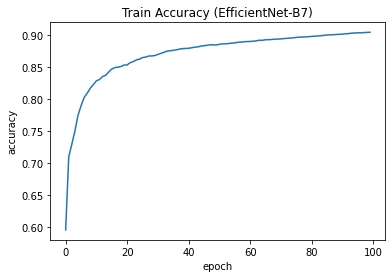

In [29]:
plt.plot(train_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train Accuracy (EfficientNet-B7)')
plt.show()

#### Save weights

In [11]:
PATH = './cifar_net(e).pth'
torch.save(efficientnetb7.to(device).state_dict(), PATH)

<a name='6'></a>
## 6 - Our Model 2

<a name='6-1'></a>
### 6.1 - Transfer Learning using Residual Network (ResNet101)

In [12]:
resnet101 = models.resnet101(pretrained=True).to(device)
for param in resnet101.parameters():
    param.requires_grad = False

resnet101.to(device).fc = nn.Linear(2048,5)
                                        
resnet101.to(device).eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<a name='6-2'></a>
### 6.2 - Defining loss function and optimizer for our model

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet101.to(device).parameters(), lr=0.001, momentum=0.9)

<a name='6-3'></a>
### 6.3 - Training the model

In [14]:
running_corrects = 0
total = 0
train_loss = []
train_acc = []

for epoch in range(100):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = resnet101(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)

        running_loss += loss.item()
        total += labels.size(0)
        running_corrects += (predicted == labels).sum().item()
        

        if i%50 == 49:
            print('[%d, %5d]    Loss: %.3f   Accuracy: %.6f'%(epoch+1,i+1,running_loss/50,running_corrects/total))
            train_loss.append(running_loss/50)
            train_acc.append(running_corrects/total)
            running_loss =0.0
            
print('Finished Training')

[1,    50]    Loss: 1.094   Accuracy: 0.596000
[2,    50]    Loss: 0.576   Accuracy: 0.710000
[3,    50]    Loss: 0.544   Accuracy: 0.729333
[4,    50]    Loss: 0.465   Accuracy: 0.750000
[5,    50]    Loss: 0.414   Accuracy: 0.774400
[6,    50]    Loss: 0.384   Accuracy: 0.789333
[7,    50]    Loss: 0.389   Accuracy: 0.802286
[8,    50]    Loss: 0.416   Accuracy: 0.809000
[9,    50]    Loss: 0.400   Accuracy: 0.816889
[10,    50]    Loss: 0.359   Accuracy: 0.822400
[11,    50]    Loss: 0.319   Accuracy: 0.828364
[12,    50]    Loss: 0.414   Accuracy: 0.830333
[13,    50]    Loss: 0.293   Accuracy: 0.835077
[14,    50]    Loss: 0.360   Accuracy: 0.836857
[15,    50]    Loss: 0.283   Accuracy: 0.842133
[16,    50]    Loss: 0.314   Accuracy: 0.846750
[17,    50]    Loss: 0.301   Accuracy: 0.848941
[18,    50]    Loss: 0.322   Accuracy: 0.849556
[19,    50]    Loss: 0.350   Accuracy: 0.850737
[20,    50]    Loss: 0.311   Accuracy: 0.853000
[21,    50]    Loss: 0.356   Accuracy: 0.853143
[

<a name='6-4'></a>
### 6.4 - Results (Training)

#### Loss Curve

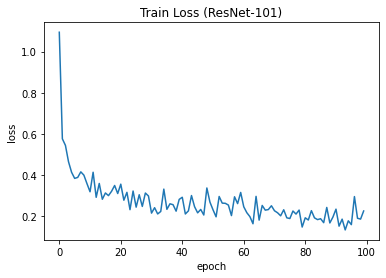

In [30]:
plt.plot(train_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train Loss (ResNet-101)')
plt.show()


#### Accuracy Curve

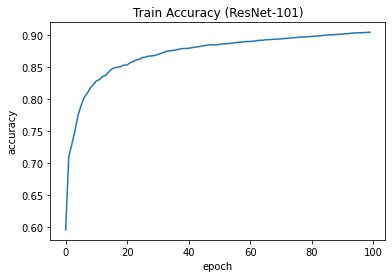

In [31]:
plt.plot(train_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train Accuracy (ResNet-101)')
plt.show()

#### Save weights

In [17]:
PATH = './cifar_net(r).pth'
torch.save(resnet101.to(device).state_dict(), PATH)

<a name='7'></a>
## 7 - Testing the 2-in-1 model


### Displaying images from testing dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


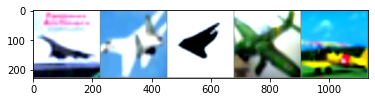

GroundTruth: airplane airplane airplane airplane airplane 


In [23]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth:',''.join('%5s ' % classes[labels[j]] for j in range(batch_size)))

### Carry out prediction

In [24]:
efficientnetb7.to(device).load_state_dict(torch.load('./cifar_net(e).pth'))
resnet101.to(device).load_state_dict(torch.load('./cifar_net(r).pth'))

outputs_e = efficientnetb7(images.to(device))
outputs_r = resnet101(images.to(device))

_, predicted = torch.max(outputs_e,1)

print('Predicted(EfficientNet-B7): ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size)))

_, predicted = torch.max(outputs_r,1)

print('Predicted(ResNet-101): ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size)))



Predicted(EfficientNet-B7):  airplane airplane airplane airplane airplane
Predicted(ResNet-101):  airplane airplane airplane airplane airplane


<a name='7-1'></a>
### 7.1 - Results (Testing)

#### Overall Accuracy

In [34]:
correct = 0
total = 0

with torch.no_grad():
   for data in testloader:
       images, labels = data
       images = images.to(device)
       labels = labels.to(device)

       outputs_e = efficientnetb7(images)
       outputs_r = resnet101(images)
       outputs_2 = (outputs_e+outputs_r)/2

       _, predicted = torch.max(outputs_2.data, 1)
       total += labels.size(0)
       correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' %(100*correct/total)) 



Accuracy: 94 %


#### Accuracy of each class

In [26]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs_e = efficientnetb7(images)
        outputs_r = resnet101(images)
        outputs_2 = (outputs_e+outputs_r)/2

        _, predictions = torch.max(outputs_2,1)
        
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100*float(correct_count)/total_pred[classname]
    print('Accuracy for class {:5s} is : {:.1f} %'.format(classname,accuracy))

Accuracy for class airplane is : 96.7 %
Accuracy for class automobile is : 96.7 %
Accuracy for class bird  is : 86.7 %
Accuracy for class cat   is : 100.0 %
Accuracy for class deer  is : 90.0 %


<a name='8'></a>
## 8 - Test on Your Own Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


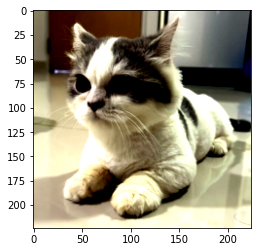

Predicted: cat


In [27]:
from PIL import Image
img_path = 'images/cat.jpg'
img = Image.open(img_path)
transform = transforms.Compose([
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
)])

img_trans = transform(img)
imshow(torchvision.utils.make_grid(img_trans))

img_trans = img_trans.unsqueeze_(0)
input = img_trans.to(device)
outputs_e = efficientnetb7(input)
outputs_r = resnet101(input)
outputs_2 = (outputs_e+outputs_r)/2
_, predicted = torch.max(outputs_2,1)
print('Predicted:',classes[predicted])
